# import packages and get authenticated

In [1]:
# from google.colab import driveA
# drive.mount('drive')

In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy.fftpack import fft, ifft
pd.set_option('display.max_columns', 500)

# Plotting
# checklist 1: comment inline, uncomment Agg
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rc( 'savefig', facecolor = 'white' )

# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import argparse
import os
import sys
sys.path.append('/content/drive/My Drive/中研院/repo/')
sys.path.append('~/project_FDDAT/repo/')
sys.path.append('../') # add this line so Data and data are visible in this file

from falldetect.utilities import *

import time
import datetime
from datetime import datetime

from sklearn.decomposition import PCA

from os.path import expanduser
home = expanduser("~")
# home_dir = home+'/project_FDDAT/'

# split_mode = 'LOO'
# split_mode = '5fold'

# Get user inputs
In ipython notebook, these are hardcoded. In production python code, use parsers to provide these inputs

In [84]:
parser = argparse.ArgumentParser(description='FD_DAT')
parser.add_argument('--dataset_name', metavar='dataset_name', help='dataset_name',
                    default='UMAFall')
parser.add_argument('--sensor_loc', metavar='sensor_loc', help='sensor_loc',
                    default='ankle')
parser.add_argument('--input_dir', metavar='input_dir', help='path to input_dir',
                    default='../')
parser.add_argument('--output_dir', metavar='output_dir', help='path to output_dir',
                    default='../')
parser.add_argument('--split_mode', metavar='split_mode', help='split_mode',
                    default='5fold')
parser.add_argument('--i_seed', type=int, metavar='i_seed', help='seed number',
                    default='0')
parser.add_argument('--standardization', metavar='standardization', help='method of standardization',
                    default='None')
parser.add_argument('--excluded_idx', metavar='excluded_idx', 
                   default='none')
# split_mode = 'LOO'
# split_mode = '5fold'

# checklist 2: comment first line, uncomment second line seizures_FN
# args = parser.parse_args(['--input_dir', '../../Data/{}/ImpactWindow_Resample_NormalforAllAxes/18hz/{}/',
#                           '--output_dir', '../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_{}/{}/{}/', 
#                           '--dataset_name', 'UMAFall', 
#                           '--sensor_loc', 'wrist',
#                           '--split_mode', '5fold',
#                           '--i_seed', '1',
#                           '--excluded_idx', '1 3 9 10 12 19',])

# # UPFall
# args = parser.parse_args(['--input_dir', '../../Data/{}/ImpactWindow_Resample_NormalforAllAxes/18hz/{}/',
#                           '--output_dir', '../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_{}/{}/{}/', 
#                           '--dataset_name', 'UPFall', 
#                           '--sensor_loc', 'ankle',
#                           '--split_mode', '5fold',
#                           '--i_seed', '1'])

# # # SFDLA
# args = parser.parse_args(['--input_dir', '../../Data/{}/ImpactWindow_Resample_NormalforAllAxes/18hz/{}/',
#                           '--output_dir', '../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_{}/{}/{}/',
# args = parser.parse_args(['--input_dir', '../../Data/{}/ImpactWindow_Resample_WithoutNormal/18hz/{}/',
#                           '--output_dir', '../../data_mic/stage1_preprocessed_WithoutNormal_18hz_{}/{}/{}/', 
args = parser.parse_args(['--input_dir', '../../Data/{}/ImpactWindow_Resample/18hz/{}/',
                          '--output_dir', '../../data_mic/stage1_preprocessed_18hz_{}/{}/{}/',
                          '--dataset_name', 'UMAFall', 
                          '--sensor_loc', 'leg',
                          '--split_mode', '5fold',
                          '--i_seed', '1',
                          '--standardization', 'None'])

                          

# args = parser.parse_args()

In [101]:
input_dir = args.input_dir
output_dir = args.output_dir
dataset_name = args.dataset_name
sensor_loc = args.sensor_loc
home_dir = home+'/project_FDDAT/'
split_mode = args.split_mode
i_seed = args.i_seed
standardization = args.standardization
if args.excluded_idx == 'none':
    excluded_idx = []
else:
    excluded_idx = list(map(int, args.excluded_idx.split(' ')))

sampling_freq = 18.4
print(args)

Namespace(dataset_name='UMAFall', excluded_idx='none', i_seed=1, input_dir='../../Data/{}/ImpactWindow_Resample/18hz/{}/', output_dir='../../data_mic/stage1_preprocessed_18hz_{}/{}/{}/', sensor_loc='leg', split_mode='5fold', standardization='None')


# load data_management (all) first

In [86]:
# resampled, 18.4hz
DataNameList_inputdir = input_dir+'IP_{}_DataNameList_{}.csv'
DataNameList_inputdir = DataNameList_inputdir.format(dataset_name, sensor_loc, dataset_name, sensor_loc)

impact_inputdir = input_dir.format(dataset_name, sensor_loc)
outputdir = output_dir.format(split_mode, dataset_name, sensor_loc)

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
print('will export data to', outputdir)

df = pd.read_csv(DataNameList_inputdir)
df.head(5)

will export data to ../../data_mic/stage1_preprocessed_18hz_5fold/UMAFall/leg/


,x_DataName,Subject,Activity_ID,Trial,Position__0_leg_1_chest_2_waist_3_wrist_4_ankle_,FALL_1__ADL_0_
0,01_Aplausing_1_leg_IP.csv,1,Aplausing,1,0,0
1,01_Aplausing_2_leg_IP.csv,1,Aplausing,2,0,0
2,01_Aplausing_3_leg_IP.csv,1,Aplausing,3,0,0
3,01_HandsUp_1_leg_IP.csv,1,HandsUp,1,0,0
4,01_HandsUp_2_leg_IP.csv,1,HandsUp,2,0,0


In [87]:
act_names = df['Activity_ID'].unique()
act_embeddings = { act_names[i] : i for i in range(0, act_names.shape[0] ) }
print(act_embeddings)

{'Aplausing': 0, 'HandsUp': 1, 'MakingACall': 2, 'OpeningDoor': 3, 'Sitting': 4, 'Walking': 5, 'Bending': 6, 'Hopping': 7, 'Jogging': 8, 'LyingDown': 9, 'backwardFall': 10, 'forwardFall': 11, 'lateralFall': 12, 'GoDownstairs': 13, 'GoUpstairs': 14}


In [88]:
if dataset_name=='UMAFall' or dataset_name=='UPFall' or dataset_name=='FARSEEING':
    column_x_DataName = 'x_DataName'
elif dataset_name=='SFDLA':
    column_x_DataName = 'x_x_DataName'

temp = pd.read_csv(impact_inputdir+df[column_x_DataName][0], header=None)

window_length = temp.shape[0]
samples_n = df.shape[0]

data_all = np.zeros((window_length,3,samples_n))
actlabels_all = np.zeros((samples_n,))
sub_all = np.zeros((samples_n,))
DataNameList_idx_all = np.zeros((samples_n,))

i = 0
for filename in tqdm(df[column_x_DataName]):
#     sub_id = int(filename.split('_')[0])
    row = df[df[column_x_DataName]==filename]
    sub_id = row.Subject.item()
    activity_id = row.FALL_1__ADL_0_.item()
    idx = row.index[0]

    position = filename.split('_')[3][:-4]
    
    df_imp = pd.read_csv(impact_inputdir+filename, header=None)

    data_all[:,:,i] = df_imp.to_numpy()
    actlabels_all[i] = activity_id
    sub_all[i] = sub_id
    DataNameList_idx_all[i] = idx
    i += 1

<ipython-input-88-02739d58e6ee>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm(df[column_x_DataName]):


In [89]:
fall_n = (actlabels_all==1).sum()
adl_n = (actlabels_all==0).sum()

print('fall_n, adl_n:', fall_n, adl_n)

fall_n, adl_n: 198 393


In [90]:
if standardization == '0 mean unit var':
    data_all = (data_all - data_all.mean()) / data_all.std()
elif standardization == 'None':
    pass

In [91]:
samples_n = data_all.shape[2]
labels_n = np.shape(np.unique(actlabels_all))[0]
subjects_n = np.shape(np.unique(sub_all))[0]
print('finished reading data in data_management {} at {}'.format(dataset_name, sensor_loc))
print('Dimension of data', data_all.shape)
print('number of activities', labels_n)
print('number of subject', subjects_n)

finished reading data in data_management UMAFall at leg
Dimension of data (66, 3, 591)
number of activities 2
number of subject 18


In [92]:
print('3 axes mean', np.mean(data_all,axis=(0,2)))
print('3 axes std', np.std(data_all,axis=(0,2)))
print('3 axes max', np.max(data_all,axis=(0,2)))
print('3 axes min', np.min(data_all,axis=(0,2)))

3 axes mean [0.47602835 0.54676444 0.51175649]
3 axes std [0.05843686 0.10779933 0.0546212 ]
3 axes max [1. 1. 1.]
3 axes min [0. 0. 0.]


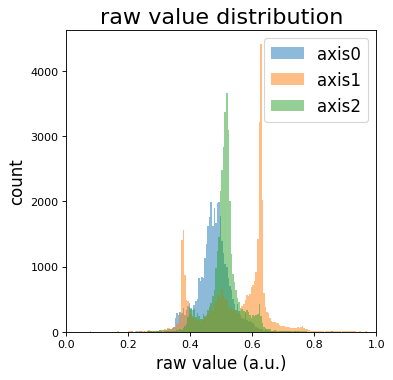

In [93]:
figure=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = figure.add_subplot(1, 1, 1)

for axis in range(data_all.shape[1]):
    ax.hist(data_all[:,axis,:].reshape(-1), 200, alpha=0.5, label='axis{}'.format(axis))
ax.legend( fontsize = 15 )
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('raw value (a.u.)', fontsize = 15)
ax.set_title('raw value distribution', fontsize = 20)

ax.set_xlim([np.min(data_all),np.max(data_all)])
# ax.set_xlim([0.3,0.4])
figure.savefig(outputdir + 'raw_distribution.png')

# plot FT distribution

In [94]:

# initialize spectral feature matrix
N = data_all.shape[0]
data_all_FT = np.zeros((N//2, 3, data_all.shape[2]))

for i_win in range(data_all_FT.shape[2]):
    for i_axis in range(data_all_FT.shape[1]): # don't do it for HR
        yf = np.abs(scipy.fftpack.fft(data_all[:,i_axis,i_win]))
        yf_scaled = 2.0/N * np.abs(yf[:N//2])
        data_all_FT[:,i_axis,i_win] = yf_scaled
    

In [95]:
# get indices for each class
indices_ADL = np.where(actlabels_all==0)[0]
data_FT_ADL = data_all_FT[:,:,indices_ADL]

indices_Fall = np.where(actlabels_all==1)[0]
data_FT_Fall = data_all_FT[:,:,indices_Fall]

In [96]:
T = 1/sampling_freq
N = data_all.shape[0]

def plot_FT_distribution(data_FT_ADL, data_FT_Fall, visual_resultsdir):
    link_adl_fall = True
    
    i_start = 1
    # grab data
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))[i_start:]

    mag_mean_Fall = np.mean(data_FT_Fall[i_start:], axis=(1,2))
    mag_var_Fall = np.var(data_FT_Fall[i_start:], axis=(1,2))

    mag_mean_ADL = np.mean(data_FT_ADL[i_start:], axis=(1,2))
    mag_var_ADL = np.var(data_FT_ADL[i_start:], axis=(1,2))

    # plt.bar(y_pos, performance, align='center', alpha=0.5)
    figure=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax = figure.add_subplot(1, 1, 1)

    ax.plot(xf, mag_mean_Fall, color = 'red', label='Fall')
    ax.fill_between(xf, mag_mean_Fall+mag_var_Fall, mag_mean_Fall-mag_var_Fall, alpha=0.3, color = 'red')

    ax.plot(xf, mag_mean_ADL, label='ADL')
    ax.fill_between(xf, mag_mean_ADL+mag_var_ADL, mag_mean_ADL-mag_var_ADL, alpha=0.3)

    ax.legend( fontsize = 15 )
    ax.set_ylabel('mag (a.u.)', fontsize = 15)
    ax.set_xlabel('freq (Hz)', fontsize = 15)
    ax.set_title('spectal engergy distribution', fontsize = 20)

    figure.savefig(visual_resultsdir + 'FT_distribution.png')

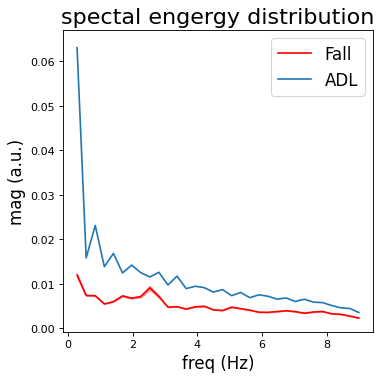

In [97]:
plot_FT_distribution(data_FT_Fall, data_FT_ADL, outputdir)

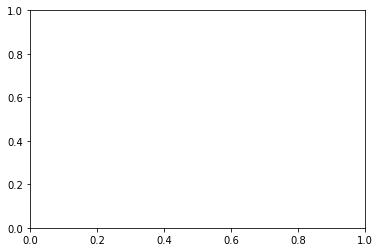

In [98]:
plt.cla()

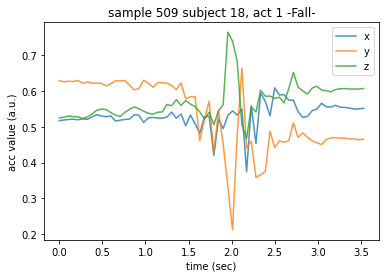

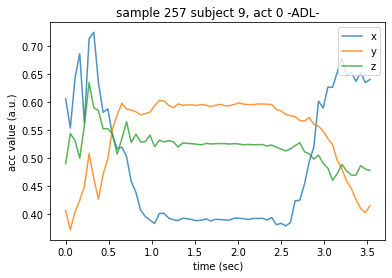

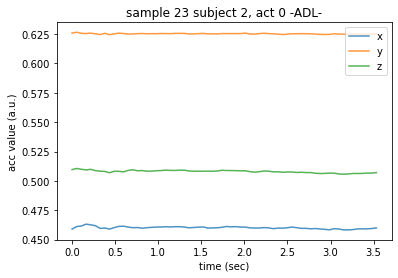

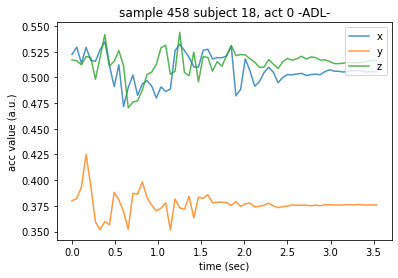

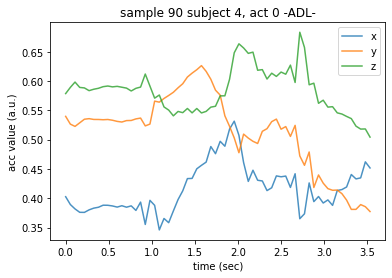

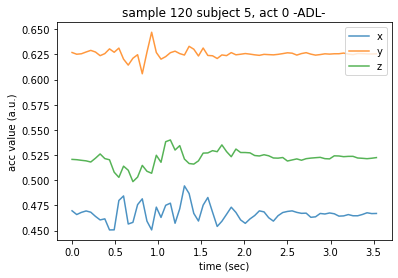

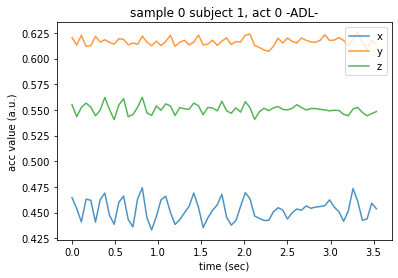

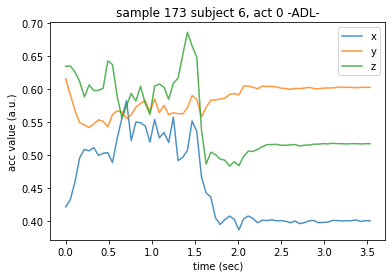

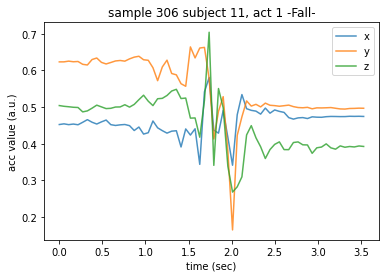

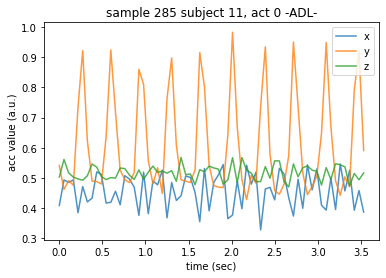

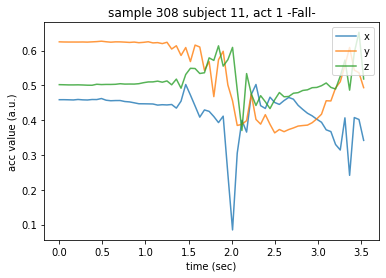

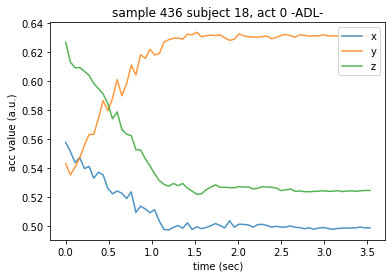

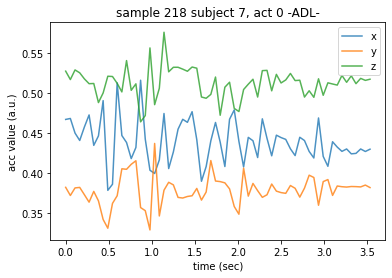

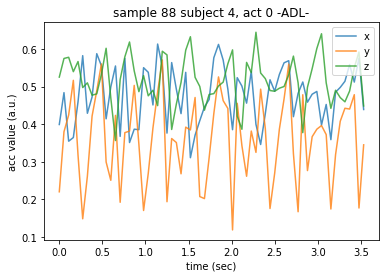

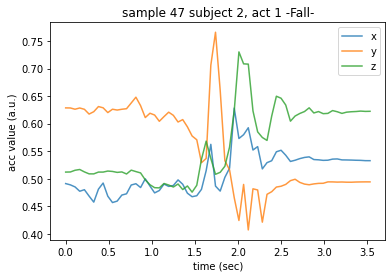

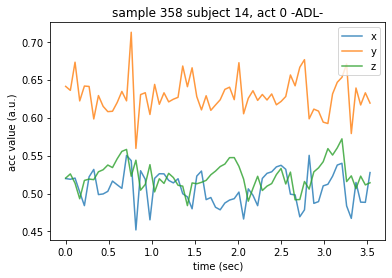

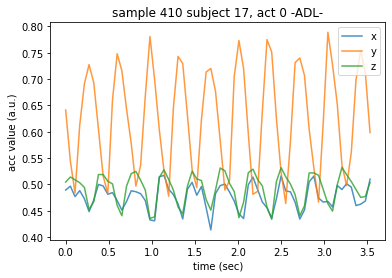

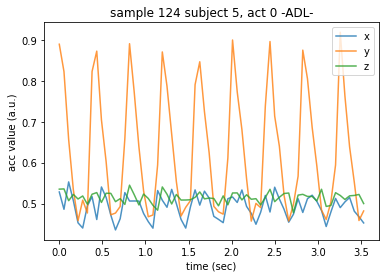

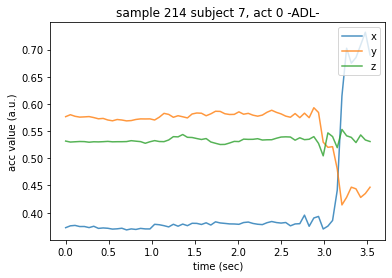

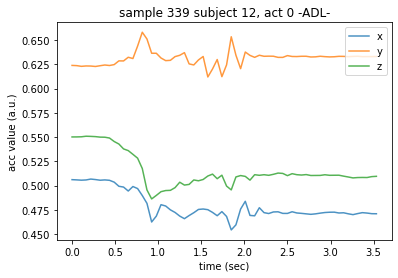

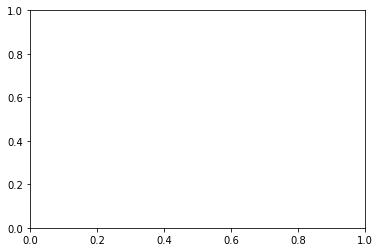

In [110]:
rand_idx = np.arange(data_all.shape[2])
np.random.seed(i_seed)
np.random.shuffle(rand_idx)

t_data = np.asarray(range(data_all.shape[0]))/sampling_freq

for idx in range(20):
    i = rand_idx[idx]
    plt.plot(t_data, data_all[:,0,i], label='x', alpha=0.8)
    plt.plot(t_data, data_all[:,1,i], label='y', alpha=0.8)
    plt.plot(t_data, data_all[:,2,i], label='z', alpha=0.8)
    plt.ylabel('acc value (a.u.)')
    plt.xlabel('time (sec)')
    plt.legend(loc='upper right')

    if actlabels_all[i] == 1:
        plt.title('sample {} subject {}, act {} -Fall-'.format(int(i), int(sub_all[i]), int(actlabels_all[i])))
    else:
        plt.title('sample {} subject {}, act {} -ADL-'.format(int(i), int(sub_all[i]), int(actlabels_all[i])))

    plt.savefig(outputdir+'i{}_sample'.format(idx))
    plt.show()
    plt.cla()


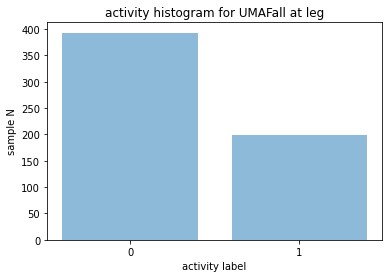

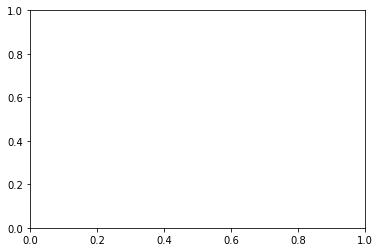

In [100]:
unique_label_id, labels_counts = np.unique(actlabels_all, return_counts=True)
unique_label_id = unique_label_id.astype(int)
y_pos = np.arange(unique_label_id.shape[0])

plt.bar(y_pos, labels_counts, align='center', alpha=0.5)
plt.xticks(y_pos, unique_label_id)

# plt.hist(actlabels_all, bins=np.arange(labels_n+1)-0.5, alpha=0.5, histtype='bar', ec='black')
# plt.xticks(range(labels_n))
plt.xlabel('activity label')
plt.ylabel('sample N')
plt.title('activity histogram for {} at {}'.format(dataset_name, sensor_loc))
plt.savefig(outputdir+'act_hist')
plt.show()
plt.cla()


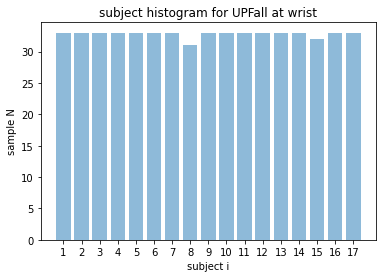

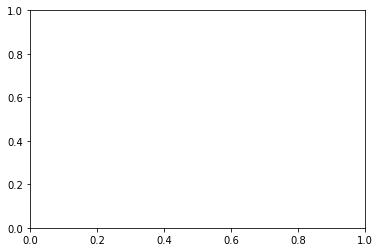

In [18]:
unique_sub_id, id_counts = np.unique(sub_all, return_counts=True)
unique_sub_id = unique_sub_id.astype(int)
y_pos = np.arange(unique_sub_id.shape[0])

plt.bar(y_pos, id_counts, align='center', alpha=0.5)
plt.xticks(y_pos, unique_sub_id)

plt.xlabel('subject i')
plt.ylabel('sample N')
plt.title('subject histogram for {} at {}'.format(dataset_name, sensor_loc))
plt.savefig(outputdir+'sub_hist')
plt.show()
plt.cla()

# split data into train and val (1:1)
split by sample_id

In [19]:
i_sub_unique_all = np.unique(sub_all)
i_sub_excluded = []

if len(excluded_idx) == 0:
    for i_sub in i_sub_unique_all:
        idx_sub = np.where(sub_all==i_sub)[0]
        idx_sub_fall = np.where(actlabels_all[idx_sub]==1)[0]

        if len(idx_sub_fall)==0:
            i_sub_excluded.append(int(i_sub))
else:
    i_sub_excluded = excluded_idx

print('i_sub {} has no fall data, will exclude'.format(i_sub_excluded))

i_sub_unique = np.array(list(set(i_sub_unique_all) - set(i_sub_excluded)))
print(i_sub_unique_all)
print(i_sub_excluded)
print(i_sub_unique)

if split_mode == 'LOO':
    CV_n = np.shape(i_sub_unique)[0]
elif split_mode == '5fold':
    CV_n = int(split_mode.split('fold')[0])
    
print('will split data into {} folds'.format(CV_n))

i_sub [] has no fall data, will exclude
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]
[]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]
will split data into 5 folds


In [20]:
from sklearn.model_selection import KFold
kfold = CV_n
kf = KFold(n_splits=kfold, shuffle=False)

i_sub_unique = np.array(list(set(i_sub_unique_all) - set(i_sub_excluded)))
print('all i_sub_unique', i_sub_unique)
np.random.seed(i_seed)
np.random.shuffle(i_sub_unique)
kf.get_n_splits(i_sub_unique)
print(kf)  

for train_index, val_index in kf.split(i_sub_unique):
    print("TRAIN:", i_sub_unique[train_index], "VAL:", i_sub_unique[val_index])

all i_sub_unique [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 7. 11.  5.  2. 15.  1. 17. 16. 10.  9. 13. 12.  6.] VAL: [ 4. 14.  8.  3.]
TRAIN: [ 4. 14.  8.  3. 15.  1. 17. 16. 10.  9. 13. 12.  6.] VAL: [ 7. 11.  5.  2.]
TRAIN: [ 4. 14.  8.  3.  7. 11.  5.  2. 16. 10.  9. 13. 12.  6.] VAL: [15.  1. 17.]
TRAIN: [ 4. 14.  8.  3.  7. 11.  5.  2. 15.  1. 17. 13. 12.  6.] VAL: [16. 10.  9.]
TRAIN: [ 4. 14.  8.  3.  7. 11.  5.  2. 15.  1. 17. 16. 10.  9.] VAL: [13. 12.  6.]


# Split based on CV results then 

In [21]:
i_CV = 0

for train_idx, val_idx in kf.split(i_sub_unique):
    print("Sub ID | TRAIN:", i_sub_unique[train_idx], "VAL:", i_sub_unique[val_idx])

    train_val_splitter(data_all, actlabels_all, sub_all, DataNameList_idx_all,
                       i_sub_unique[train_idx], i_sub_unique[val_idx], outputdir+'CV'+str(i_CV))

    i_CV = i_CV + 1


Sub ID | TRAIN: [ 7. 11.  5.  2. 15.  1. 17. 16. 10.  9. 13. 12.  6.] VAL: [ 4. 14.  8.  3.]
train dimensions: (66, 3, 428) (428,) (428,) (428,)
val dimensions: (66, 3, 130) (130,) (130,) (130,)
outputdir for train: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UPFall/wrist/CV0/train
outputdir for val: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UPFall/wrist/CV0/val
outputdir for data: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UPFall/wrist/CV0/train/data.npz
Are data save and loadded correctly?  True

outputdir for labels: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UPFall/wrist/CV0/train/labels.npz
Are labels save and loadded correctly?  True

outputdir for i_sub: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UPFall/wrist/CV0/train/i_sub.npz
Are i_sub save and loadded correctly?  True

outputdir for DataNameList_idx: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UPFall/wrist/C